In [84]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression,SGDRegressor, SGDClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import PolynomialFeatures
import time
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

데이터 로드 및 전처리
---

In [85]:
# 데이터 로드
data = pd.read_csv('Stateofsewage.csv')

In [86]:
# 날짜를 주기적 특성으로 변환
data['Year'] = pd.to_datetime(data['Sampling Date']).dt.year
data['DayOfYear'] = pd.to_datetime(data['Sampling Date']).dt.dayofyear

data['Year_Sin'] = np.sin(2 * np.pi * data['Year'] / 10)  # 10년 주기로 가정
data['Year_Cos'] = np.cos(2 * np.pi * data['Year'] / 10)
data['Day_Sin'] = np.sin(2 * np.pi * data['DayOfYear'] / 365)
data['Day_Cos'] = np.cos(2 * np.pi * data['DayOfYear'] / 365)

In [87]:
# 위도와 경도를 표준화
scaler = StandardScaler()
data[['Latitude', 'Longitude']] = scaler.fit_transform(data[['Geographical Location (Latitude)', 'Geographical Location (Longitude)']])

In [90]:
# 새로운 기준으로 State of Sewage System 정의
def redefine_state(row):
    total = row['Nitrogen (mg/L)'] + row['Phosphorus (mg/L)']
    if total <= 5:
        return 'Good'
    elif 5 < total <= 11:
        return 'Moderate'
    else:
        return 'Poor'

# 새로운 State 값 생성
data['State of Sewage System'] = data.apply(redefine_state, axis=1)

# 라벨 데이터 매핑 (Good -> 2, Moderate -> 1, Poor -> 0)
label_mapping = {'Good': 2, 'Moderate': 1, 'Poor': 0}
data['Label'] = data['State of Sewage System'].map(label_mapping)

In [91]:
# # 라벨 데이터 매핑 (Good -> 2, Moderate -> 1, Poor -> 0)
# label_mapping = {'Good': 2, 'Moderate': 1, 'Poor': 0}
# data['Label'] = data['State of Sewage System'].map(label_mapping) 

In [92]:
# 입력 및 라벨 분리
X = data[['Latitude', 'Longitude', 'Year_Sin', 'Year_Cos', 'Day_Sin', 'Day_Cos']]
y_regression = data[['Nitrogen (mg/L)', 'Phosphorus (mg/L)']]
y_classification = data['Label']

In [93]:
# 데이터 분리
X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
    X, y_regression, y_classification, test_size=0.2, random_state=42
)

Polynomial Regression (HPSM, HPKM)
--

In [26]:
# 다항식 생성
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


In [27]:
# Polynomial Regression (Mini-batch SGD)
batch_size = 64
learning_rate = 0.01
kf = KFold(n_splits=5)

In [79]:
def train_sgd(X, y):
    sgd = SGDRegressor(loss='squared_error', learning_rate='constant', eta0=learning_rate, random_state=42)
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        # Mini-batch SGD
        for i in range(0, len(X_train_fold), batch_size):
            X_batch = X_train_fold[i:i + batch_size]
            y_batch = y_train_fold[i:i + batch_size]
            sgd.partial_fit(X_batch, y_batch)
        
        # 검증 데이터로 손실 계산
        y_val_pred = sgd.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_val_pred)
        # print(f"Validation MSE: {mse:.4f}")
    return sgd

In [31]:
# Nitrogen 및 Phosphorus 모델 학습
print("Nitrogen Model")
sgd_nitrogen = train_sgd(X_train_poly, y_reg_train['Nitrogen (mg/L)'].values)
print("\nPhosphorus Model")
sgd_phosphorus = train_sgd(X_train_poly, y_reg_train['Phosphorus (mg/L)'].values)

Nitrogen Model
Validation MSE: 9.2441
Validation MSE: 9.1848
Validation MSE: 9.0436
Validation MSE: 9.3574
Validation MSE: 9.0086

Phosphorus Model
Validation MSE: 2.2653
Validation MSE: 2.2485
Validation MSE: 2.1866
Validation MSE: 2.2103
Validation MSE: 2.1904


Softmax Regression
--

In [62]:
# 표준화
mean_nitrogen = np.mean(sgd_nitrogen.predict(X_train_poly))
std_nitrogen = np.std(sgd_nitrogen.predict(X_train_poly))
mean_phosphorus = np.mean(sgd_phosphorus.predict(X_train_poly))
std_phosphorus = np.std(sgd_phosphorus.predict(X_train_poly))

X_train_softmax = np.column_stack([
    (sgd_nitrogen.predict(X_train_poly) - mean_nitrogen) / std_nitrogen,
    (sgd_phosphorus.predict(X_train_poly) - mean_phosphorus) / std_phosphorus
])
X_test_softmax = np.column_stack([
    (sgd_nitrogen.predict(X_test_poly) - mean_nitrogen) / std_nitrogen,
    (sgd_phosphorus.predict(X_test_poly) - mean_phosphorus) / std_phosphorus
])

In [59]:
def train_softmax(X, y):
    softmax_model = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=learning_rate, random_state=42)
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Mini-batch SGD
        for i in range(0, len(X_train_fold), batch_size):
            X_batch = X_train_fold[i:i + batch_size]
            y_batch = y_train_fold.iloc[i:i + batch_size]
            softmax_model.partial_fit(X_batch, y_batch, classes=np.unique(y))

        # 검증 데이터로 Cross-Entropy Loss 및 정확도 계산
        y_val_pred_proba = softmax_model.predict_proba(X_val_fold) 
        cross_entropy = log_loss(y_val_fold, y_val_pred_proba) 
        y_val_pred = softmax_model.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_val_pred) 
        
        print(f"Validation Accuracy: {accuracy:.4f}, Cross-Entropy Loss: {cross_entropy:.4f}")
    
    return softmax_model

In [60]:
# y_class_test = np.array(y_class_test)

In [61]:
# Softmax Regression 학습
print("Softmax Regression Model")
softmax_model = train_softmax(X_train_softmax, y_class_train)


Softmax Regression Model
Validation Accuracy: 0.5847, Cross-Entropy Loss: 0.9572
Validation Accuracy: 0.5929, Cross-Entropy Loss: 0.9513
Validation Accuracy: 0.5927, Cross-Entropy Loss: 0.9517
Validation Accuracy: 0.5871, Cross-Entropy Loss: 0.9584
Validation Accuracy: 0.5981, Cross-Entropy Loss: 0.9514


KNN
--

In [37]:
#표준화
X_train_knn = np.column_stack([
    (sgd_nitrogen.predict(X_train_poly) - mean_nitrogen) / std_nitrogen,
    (sgd_phosphorus.predict(X_train_poly) - mean_phosphorus) / std_phosphorus
])
X_test_knn = np.column_stack([
    (sgd_nitrogen.predict(X_test_poly) - mean_nitrogen) / std_nitrogen,
    (sgd_phosphorus.predict(X_test_poly) - mean_phosphorus) / std_phosphorus
])

In [65]:
# 2. KNN 모델 학습 및 성능 비교
def train_knn(X, y, k_values):
    kf = KFold(n_splits=5)
    best_k = None
    best_accuracy = 0

    for k in k_values:
        print(f"\nk = {k}")
        knn_model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        fold_accuracies = []

        for fold, (train_index, val_index) in enumerate(kf.split(X)):
            X_train_fold, X_val_fold = X[train_index], X[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

            # 학습 및 검증
            knn_model.fit(X_train_fold, y_train_fold)
            y_val_pred = knn_model.predict(X_val_fold)
            accuracy = accuracy_score(y_val_fold, y_val_pred)
            fold_accuracies.append(accuracy)

            print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")

        # k 값별 평균 정확도 계산
        mean_accuracy = np.mean(fold_accuracies)

        # 최적의 k 값 업데이트
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_k = k

    print(f"\nBest k: {best_k}, Accuracy: {best_accuracy:.4f}")
    return best_k

In [66]:
# 3. 최적의 k 값 찾기
k_values = [3, 5, 7]
best_k = train_knn(X_train_knn, y_class_train, k_values)


k = 3
Fold 1 Accuracy: 0.8370
Fold 2 Accuracy: 0.8399
Fold 3 Accuracy: 0.8509
Fold 4 Accuracy: 0.8413
Fold 5 Accuracy: 0.8348

k = 5
Fold 1 Accuracy: 0.6604
Fold 2 Accuracy: 0.6535
Fold 3 Accuracy: 0.6565
Fold 4 Accuracy: 0.6585
Fold 5 Accuracy: 0.6447

k = 7
Fold 1 Accuracy: 0.6111
Fold 2 Accuracy: 0.6097
Fold 3 Accuracy: 0.6078
Fold 4 Accuracy: 0.6019
Fold 5 Accuracy: 0.6085

Best k: 3, Accuracy: 0.8408


In [ ]:
# 4. 테스트 데이터 평가

knn_model = KNeighborsClassifier(n_neighbors=3, metric='euclidean') # 최적의 k 값 사용
knn_model.fit(X_train_knn, y_class_train)

y_pred_class_knn = knn_model.predict(X_test_knn)
accuracy_knn = accuracy_score(y_class_test, y_pred_class_knn)
print(f"Test Accuracy (KNN, k={best_k}): {accuracy_knn:.4f}")

Test Accuracy (KNN, k=3): 0.9411


모델 평가
--

In [70]:
# Nitrogen과 Phosphorus의 MSE 계산 (Polynomial Regression)
mse_nitrogen = mean_squared_error(y_reg_test['Nitrogen (mg/L)'], sgd_nitrogen.predict(X_test_poly))
mse_phosphorus = mean_squared_error(y_reg_test['Phosphorus (mg/L)'], sgd_phosphorus.predict(X_test_poly))

print(f"MSE (Nitrogen): {mse_nitrogen:.4f}")
print(f"MSE (Phosphorus): {mse_phosphorus:.4f}")

MSE (Nitrogen): 9.2843
MSE (Phosphorus): 2.1804


In [73]:
# HPSM 모델 정확도
y_pred_class = softmax_model.predict(X_test_softmax)
test_accuracy = accuracy_score(y_class_test, y_pred_class)
print("--- HPSM Model ---")
print(f"\nTest Accuracy: {test_accuracy:.4f}")

--- HPSM Model ---

Test Accuracy: 0.5922


In [72]:
# HPSM Precision, Recall, F1-score 계산
report = classification_report(y_class_test, y_pred_class, target_names=['Poor', 'Moderate', 'Good'])
print(report)

              precision    recall  f1-score   support

        Poor       0.00      0.00      0.00      1270
    Moderate       0.59      1.00      0.74      4747
        Good       0.00      0.00      0.00      1999

    accuracy                           0.59      8016
   macro avg       0.20      0.33      0.25      8016
weighted avg       0.35      0.59      0.44      8016



c:\Users\ppjw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ppjw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ppjw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [74]:
#HPKM 모델 정확도

y_pred_class_knn = knn_model.predict(X_test_knn)
accuracy_knn = accuracy_score(y_class_test, y_pred_class_knn)
print("--- HPKM Model ---")
print(f"Test Accuracy (KNN, k={best_k}): {accuracy_knn:.4f}")

--- HPKM Model ---
Test Accuracy (KNN, k=3): 0.9411


In [75]:
# HPKM Precision, Recall, F1-score
report_knn = classification_report(y_class_test, y_pred_class_knn, target_names=['Poor', 'Moderate', 'Good'])
print(report_knn)

              precision    recall  f1-score   support

        Poor       0.90      0.92      0.91      1270
    Moderate       0.96      0.95      0.96      4747
        Good       0.92      0.92      0.92      1999

    accuracy                           0.94      8016
   macro avg       0.93      0.93      0.93      8016
weighted avg       0.94      0.94      0.94      8016



Polynomial 없는 Softmax Regression
--

In [81]:
# Softmax Regression 직접 분류
softmax_direct_model = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.01, random_state=42)
start_time_softmax = time.time()

# Softmax 학습 (Mini-batch SGD)
for i in range(0, len(X_train), 64):
    X_batch = X_train.iloc[i:i + 64]
    y_batch = y_class_train.iloc[i:i + 64]
    softmax_direct_model.partial_fit(X_batch, y_batch, classes=np.unique(y_class_train))

end_time_softmax = time.time()
softmax_train_time = end_time_softmax - start_time_softmax

# Softmax 테스트
softmax_pred = softmax_direct_model.predict(X_test)
softmax_accuracy = accuracy_score(y_class_test, softmax_pred)
softmax_report = classification_report(y_class_test, softmax_pred, target_names=['Poor', 'Moderate', 'Good'])

print("--- Direct Softmax Regression ---")
print(f"Training Time: {softmax_train_time:.4f} seconds")
print(f"Test Accuracy: {softmax_accuracy:.4f}")
print(softmax_report)

--- Direct Softmax Regression ---
Training Time: 1.2815 seconds
Test Accuracy: 0.5922
              precision    recall  f1-score   support

        Poor       0.00      0.00      0.00      1270
    Moderate       0.59      1.00      0.74      4747
        Good       0.00      0.00      0.00      1999

    accuracy                           0.59      8016
   macro avg       0.20      0.33      0.25      8016
weighted avg       0.35      0.59      0.44      8016



c:\Users\ppjw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ppjw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ppjw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [76]:
import time

In [94]:
# Polynomial Regression 학습 시간 측정
def train_polynomial_regression():
    start_time_poly = time.time()
    
    # Nitrogen 및 Phosphorus Polynomial Regression 학습
    sgd_nitrogen = train_sgd(X_train_poly, y_reg_train['Nitrogen (mg/L)'].values)
    sgd_phosphorus = train_sgd(X_train_poly, y_reg_train['Phosphorus (mg/L)'].values)

    poly_training_time = time.time() - start_time_poly
    return sgd_nitrogen, sgd_phosphorus, poly_training_time

# Polynomial Regression 학습
sgd_nitrogen, sgd_phosphorus, poly_training_time = train_polynomial_regression()

# HPSM 학습 시간 측정
start_time_hpsm = time.time()

# Softmax Regression (HPSM)
X_train_softmax = np.column_stack([
    (sgd_nitrogen.predict(X_train_poly) - mean_nitrogen) / std_nitrogen,
    (sgd_phosphorus.predict(X_train_poly) - mean_phosphorus) / std_phosphorus
])
X_test_softmax = np.column_stack([
    (sgd_nitrogen.predict(X_test_poly) - mean_nitrogen) / std_nitrogen,
    (sgd_phosphorus.predict(X_test_poly) - mean_phosphorus) / std_phosphorus
])

softmax_model = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=learning_rate, random_state=42)
for i in range(0, len(X_train_softmax), batch_size):
    X_batch = X_train_softmax[i:i + batch_size]
    y_batch = y_class_train.iloc[i:i + batch_size]
    softmax_model.partial_fit(X_batch, y_batch, classes=np.unique(y_class_train))

hpsm_training_time = time.time() - start_time_hpsm

# HPKM 학습 시간 측정
start_time_hpkm = time.time()

# KNN 학습 (k = 최적의 k 값)
X_train_knn = np.column_stack([
    (sgd_nitrogen.predict(X_train_poly) - mean_nitrogen) / std_nitrogen,
    (sgd_phosphorus.predict(X_train_poly) - mean_phosphorus) / std_phosphorus
])
X_test_knn = np.column_stack([
    (sgd_nitrogen.predict(X_test_poly) - mean_nitrogen) / std_nitrogen,
    (sgd_phosphorus.predict(X_test_poly) - mean_phosphorus) / std_phosphorus
])

best_k = 3  # 이전 단계에서 최적의 k로 결정된 값
knn_model = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
knn_model.fit(X_train_knn, y_class_train)

hpkm_training_time = time.time() - start_time_hpkm

# 전체 학습 시간 계산
hpsm_total_time = poly_training_time + hpsm_training_time
hpkm_total_time = poly_training_time + hpkm_training_time

print(f"HPSM Training Time: {hpsm_total_time:.4f} seconds")
print(f"HPKM Training Time: {hpkm_total_time:.4f} seconds")



HPSM Training Time: 4.8192 seconds
HPKM Training Time: 2.9954 seconds


In [ ]:
# HPKM 학습 시간 측정

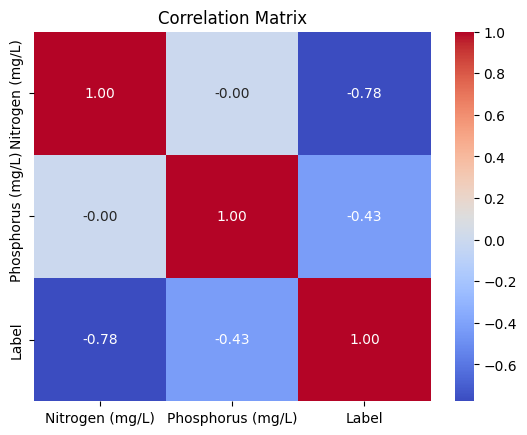

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt


# 상관관계를 계산할 열만 선택
numeric_columns = ['Nitrogen (mg/L)', 'Phosphorus (mg/L)', 'Label']
corr_matrix = data[numeric_columns].corr()

# 상관관계 시각화
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

plt.show()

In [73]:
print(data['State of Sewage System'].value_counts())

Series([], Name: count, dtype: int64)


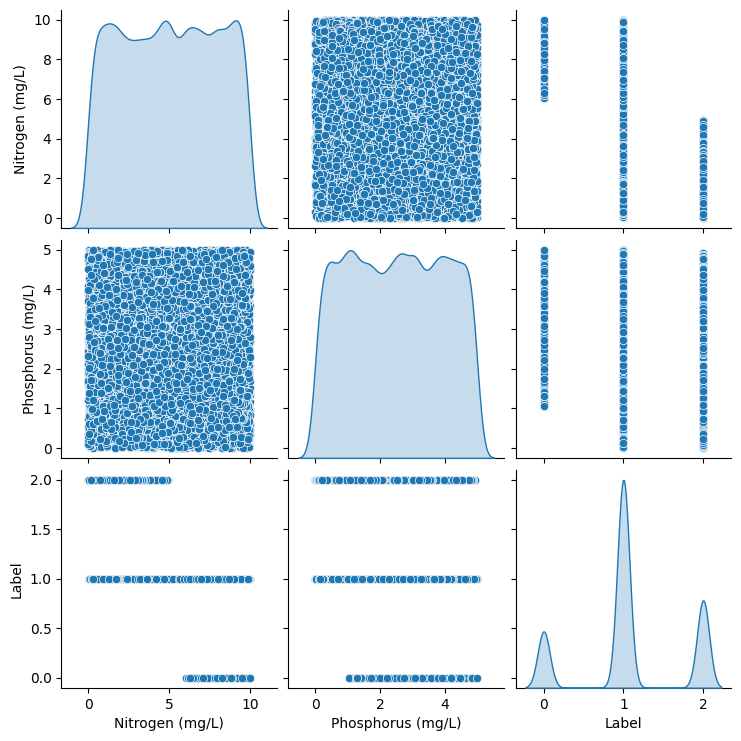

In [69]:
sns.pairplot(data[['Nitrogen (mg/L)', 'Phosphorus (mg/L)', 'Label']], diag_kind='kde')
plt.show()

In [67]:
print(data['State of Sewage System'].value_counts())


Series([], Name: count, dtype: int64)
